In [1]:
import os
import time
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="* -3 -4"))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp
import torchvision

import torchio as tio

import matplotlib.pyplot as plt
from IPython.display import display
import nibabel as nib
from torch.utils.checkpoint import checkpoint

from sklearn.model_selection import KFold

from mdl_seg_class.metrics import dice3d, dice2d
from mdl_seg_class.visualization import display_seg
from curriculum_deeplab.mindssc import mindssc

import wandb
import random
import glob
import re
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

from curriculum_deeplab.data_parameters import DataParamMode, DataParamOptim
from curriculum_deeplab.data_parameters import DataParameterManager

print(torch.__version__)
print(torch.backends.cudnn.version())
# print(torch.cuda.get_device_name(0))


### Recommended gpus on this machine (descending order) ###
  ID  Card name                     Util    Mem free  Cuda             User(s)
----  --------------------------  ------  ----------  ---------------  ---------
   0  NVIDIA GeForce RTX 2080 Ti     0 %    5963 MiB  11.5(495.29.05)  falta
   3  NVIDIA GeForce RTX 2080 Ti     0 %    2083 MiB  11.5(495.29.05)  falta
   1  NVIDIA GeForce RTX 2080 Ti    30 %    4872 MiB  11.5(495.29.05)  popp
   2  NVIDIA GeForce RTX 2080 Ti  ! 97 %    4898 MiB  11.5(495.29.05)  popp

Will apply following mapping

  ID  Card name                       torch
----  --------------------------  --  -------
   0  NVIDIA GeForce RTX 2080 Ti  ->  cuda:0
1.9.1+cu102
7605


In [123]:
def interpolate_sample(b_image, b_label, scale_factor, yield_2d):
    
    if yield_2d:
        scale = [scale_factor]*2
        im_mode = 'bilinear'
    else:
        scale = [scale_factor]*3
        im_mode = 'trilinear'
    
    b_image = F.interpolate(
        b_image.unsqueeze(1), scale_factor=scale, mode=im_mode, align_corners=True
    )

    b_label = F.interpolate(
        b_label.unsqueeze(1).float(), scale_factor=scale, mode='nearest').long()
    
    return b_image.squeeze(1), b_label.squeeze(1)



def dilate_label_class(b_label, class_max_idx, class_dilate_idx, 
                       yield_2d, kernel_sz=3):
    
    if kernel_sz < 2:
        return b_label
    
    b_dilated_label = b_label
    
    b_onehot = torch.nn.functional.one_hot(b_label.long(), class_max_idx+1)
    class_slice = b_onehot[...,class_dilate_idx]
    
    if yield_2d:
        B, H, W = class_slice.shape
        kernel = torch.ones([kernel_sz,kernel_sz]).long()
        kernel = kernel.view(1,1,kernel_sz,kernel_sz)
        class_slice = torch.nn.functional.conv2d(
            class_slice.view(B,1,H,W), kernel, padding='same')
        
    else:
        B, D, H, W = class_slice.shape
        kernel = torch.ones([kernel_sz,kernel_sz,kernel_sz])
        kernel = kernel.long().view(1,1,kernel_sz,kernel_sz,kernel_sz)
        class_slice = torch.nn.functional.conv3d(
            class_slice.view(B,1,D,H,W), kernel, padding='same')
        
    dilated_class_slice = torch.clamp(class_slice.squeeze(0), 0, 1)
    b_dilated_label[dilated_class_slice.bool()] = class_dilate_idx
    
    return b_dilated_label


def get_batch_dice_per_class(b_dice, class_tags, exclude_bg=True) -> dict:
    score_dict = {}
    for cls_idx, cls_tag in enumerate(class_tags):
        if exclude_bg and cls_idx == 0:
            continue
            
        if torch.all(torch.isnan(b_dice[:,cls_idx])):
            score = float('nan')
        else:
            score = np.nanmean(b_dice[:,cls_idx:]).item()

        score_dict[cls_tag] = score
        
    return score_dict

def get_batch_dice_over_all(b_dice, exclude_bg=True) -> float: 
    start_idx = 1 if exclude_bg else 0
    if torch.all(torch.isnan(b_dice[:,start_idx:])):
        return float('nan')
    return np.nanmean(b_dice[:,start_idx:]).item()



def get_2d_stack_batch_size(b_input_size: torch.Size, stack_dim):
    assert len(b_input_size) == 5, f"Input size must be 5D: BxCxDxHxW but is {b_input_size}"
    if stack_dim == "D":
        return b_input_size[0]*b_input_size[2]
    if stack_dim == "H":
        return b_input_size[0]*b_input_size[3]
    if stack_dim == "W":
        return b_input_size[0]*b_input_size[4]
    else:
        raise ValueError(f"stack_dim '{stack_dim}' must be 'D' or 'H' or 'W'.")

        
        
def make_2d_stack_from_3d(b_input, stack_dim):
    assert b_input.dim() == 5, f"Input must be 5D: BxCxDxHxW but is {b_input.shape}"
    B, C, D, H, W = b_input.shape
    
    if stack_dim == "D":
        return b_input.permute(0, 2, 1, 3, 4).reshape(B*D, C, H, W)
    if stack_dim == "H":
        return b_input.permute(0, 3, 1, 2, 4).reshape(B*H, C, D, W)
    if stack_dim == "W":
        return b_input.permute(0, 4, 1, 2, 3).reshape(B*W, C, D, H)
    else:
        raise ValueError(f"stack_dim '{stack_dim}' must be 'D' or 'H' or 'W'.")
        
    
    
def make_3d_from_2d_stack(b_input, stack_dim, orig_stack_size):
    assert b_input.dim() == 4, f"Input must be 4D: (orig_batch_size/B)xCxSPAT1xSPAT0 but is {b_input.shape}"
    B, C, SPAT1, SPAT0 = b_input.shape
    b_input = b_input.reshape(orig_stack_size, int(B//orig_stack_size), C, SPAT1, SPAT0)

    if stack_dim == "D":
        return b_input.permute(0, 2, 1, 3, 4)
    if stack_dim == "H":
        return b_input.permute(0, 2, 3, 1, 4)
    if stack_dim == "W":
        return b_input.permute(0, 2, 3, 4, 1)
    else:
        raise ValueError(f"stack_dim is '{stack_dim}' but must be 'D' or 'H' or 'W'.")

In [124]:
def augmentBspline(b_image, b_label, num_ctl_points=7, strength=0.05, yield_2d=False):
    """
    2D/3D b-spline augmentation on image and segmentation mini-batch on GPU.
    :input: b_image batch (torch.cuda.FloatTensor), b_label batch (torch.cuda.LongTensor)
    :return: augmented Bx(D)xHxW image batch (torch.cuda.FloatTensor), 
    augmented Bx(D)xHxW seg batch (torch.cuda.LongTensor)
    """

    KERNEL_SIZE = 3

    if yield_2d:
        assert b_image.dim() == b_label.dim() == 3, \
            f"Augmenting 2D. Input batch of image and " \
            f"label should be BxHxW but are {b_image.shape} and {b_label.shape}"
        B,H,W = b_image.shape
        
        bspline = torch.nn.Sequential(
            nn.AvgPool2d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2)),
            nn.AvgPool2d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2)),
            nn.AvgPool2d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2))
        )
        # Add an extra *.5 factor to dim strength to make strength fit 3D case
        dim_strength = (torch.tensor([H,W]).float()*strength*.5).to(b_image.device)
        rand_control_points = dim_strength.view(1,2,1,1) * torch.randn(
            1, 2, num_ctl_points, num_ctl_points
        ).to(b_image.device)
        
        bspline_disp = bspline(rand_control_points)
        bspline_disp = torch.nn.functional.interpolate(
            bspline_disp, size=(H,W), mode='bilinear', align_corners=True
        ).permute(0,2,3,1)
    
        identity = torch.eye(2,3).expand(B,2,3).to(b_image.device)
        
        id_grid = F.affine_grid(identity, torch.Size((B,2,H,W)), 
            align_corners=False)

    else:
        assert b_image.dim() == b_label.dim() == 4, \
            f"Augmenting 3D. Input batch of image and " \
            f"label should be BxDxHxW but are {b_image.shape} and {b_label.shape}"
        B,D,H,W = b_image.shape
        
        bspline = torch.nn.Sequential(
            nn.AvgPool3d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2)),
            nn.AvgPool3d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2)),
            nn.AvgPool3d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2))
        )
        dim_strength = (torch.tensor([D,H,W]).float()*strength).to(b_image.device)
        rand_control_points = dim_strength.view(1,3,1,1,1) * torch.randn(
            1, 3, num_ctl_points, num_ctl_points, num_ctl_points
        ).to(b_image.device)

        bspline_disp = bspline(rand_control_points)

        bspline_disp = torch.nn.functional.interpolate(
            bspline_disp, size=(D,H,W), mode='trilinear', align_corners=True
        ).permute(0,2,3,4,1)
    
        identity = torch.eye(3,4).expand(B,3,4).to(b_image.device)
        
        id_grid = F.affine_grid(identity, torch.Size((B,3,D,H,W)), 
            align_corners=False)

    b_image_out = F.grid_sample(
        b_image.unsqueeze(1).float(), id_grid + bspline_disp, 
        padding_mode='border', align_corners=False)
    b_label_out = F.grid_sample(
        b_label.unsqueeze(1).float(), id_grid + bspline_disp, 
        mode='nearest', align_corners=False)

    return b_image_out.squeeze(1), b_label_out.squeeze(1).long()



def augmentAffine(b_image, b_label, strength=0.05, yield_2d=False):
    """
    2D/3D affine augmentation on image and segmentation mini-batch on GPU.
    (affine transf. is centered: trilinear interpolation and zero-padding used for sampling)
    :input: b_image batch (torch.cuda.FloatTensor), b_label batch (torch.cuda.LongTensor)
    :return: augmented Bx(D)xHxW image batch (torch.cuda.FloatTensor), 
    augmented Bx(D)xHxW seg batch (torch.cuda.LongTensor)
    """
    if yield_2d:
        assert b_image.dim() == b_label.dim() == 3, \
            f"Augmenting 2D. Input batch of image and " \
            f"label should be BxHxW but are {b_image.shape} and {b_label.shape}"
        B,H,W = b_image.shape
        
        affine_matrix = (torch.eye(2,3).unsqueeze(0) + torch.randn(B,2,3) \
                         * strength).to(b_image.device)

        meshgrid = F.affine_grid(affine_matrix, torch.Size((B,1,H,W)), 
                                 align_corners=False)
    else:
        assert b_image.dim() == b_label.dim() == 4, \
            f"Augmenting 3D. Input batch of image and " \
            f"label should be BxDxHxW but are {b_image.shape} and {b_label.shape}"
        B,D,H,W = b_image.shape
        
        affine_matrix = (torch.eye(3,4).unsqueeze(0) + torch.randn(B,3,4) \
                         * strength).to(b_image.device)

        meshgrid = F.affine_grid(affine_matrix,torch.Size((B,1,D,H,W)), 
                                 align_corners=False)
        
    b_image_out = F.grid_sample(
        b_image.unsqueeze(1).float(), meshgrid, padding_mode='border', align_corners=False)
    b_label_out = F.grid_sample(
        b_label.unsqueeze(1).float(), meshgrid, mode='nearest', align_corners=False)

    return b_image_out.squeeze(1), b_label_out.squeeze(1).long()



def augmentNoise(b_image, strength=0.05):
    return b_image + strength*torch.randn_like(b_image)

In [125]:
from pathlib import Path

class CrossMoDa_Data(Dataset):
    def __init__(self,
        base_dir, domain, state,
        ensure_labeled_pairs=True, use_additional_data=False, resample=True,
        size:tuple=(96,96,60), normalize:bool=True, 
        max_load_num=None, crop_w_dim_range=None,
        disturbed_idxs=None, yield_2d_normal_to=None, flip_r_samples=True,
        dilate_kernel_sz=3,
    ):
        
        """
        Function to create Dataset structure with crossMoDa data.
        The function allows to use different preproccessing steps of the crossMoDa data set
        and using additinal data from TCIA database.
        The data can also be resampled to a desired size and normalized to mean=0 and std=1.

        Parameters:
                base_dir (os.Pathlike): provide the directory which contains "L1..." to "L4..." directories
                domain (str): choose which domain to load. Can be set to "source", "target" or "validation". Source are ceT1, target and validation hrT2 images.

                state (str): state of preprocessing:    "l1" = original data,
                                                        "l2" = resampled data @ 0.5mm,
                                                        "l3" = center-cropped data,
                                                        "l4" = image specific crops for desired anatomy

                ensure_labeled_pairs (bool): Only images with corresponding labels will be loaded (default: True)
                
                use_additional_data (bool): set to True to use additional data from TCIA (default: False)

                resample (bool): set to False to disable resampling to desired size (default: True)

                size (tuple): 3d-tuple(int) to which the data is resampled. Unused if resample=False. (default: (96,96,60)).
                    WARNING: choosing large sizes or not resampling can lead to excess memory usage

                normalize (bool): set to False to disable normalization to mean=0, std=1 for each image (default: True)
                max_load_num (int): maximum number of pairs to load (uses first max_load_num samples for either images and labels found)
                crop_w_dim_range (tuple): Tuple of ints defining the range to which dimension W of (D,H,W) is cropped
                yield_2d_normal_to (bool):
                
        Returns:
                torch.utils.data.Dataset containing CrossMoDa data

        Useful Links:
        CrossMoDa challenge:
        https://crossmoda.grand-challenge.org/

        ToDos:
            extend to other preprocessing states

        Example:
            dataset = CrossMoDa_source('original')

            data = dataset.get_data()

        """
        
        self.disturbed_idxs = disturbed_idxs
        self.yield_2d_normal_to = yield_2d_normal_to
        self.do_train = False
        self.augment_at_collate = False
        self.dilate_kernel_sz = dilate_kernel_sz
        
        #define finished preprocessing states here with subpath and default size
        states = {
            'l1':('L1_original/', (512,512,160)),
            'l2':('L2_resampled_05mm/', (420,420,360)),
            'l3':('L3_coarse_fixed_crop/', (128,128,192)),
            'l4':('L4_fine_localized_crop/', (128,128,128))
        }
        t0 = time.time()
        #choose directory with data according to chosen preprocessing state
        if state not in states: raise Exception("Unknown state. Choose one of: "+str(states.keys))
        
        state_dir = states[state.lower()][0] #get sub directory
        
        if not resample: size = states[state.lower()][1] #set size to default defined at top of file
        
        path = base_dir + state_dir
        
        #get file list
        if domain.lower() =="ceT1" or domain.lower() =="source":
            directory = "source_training_labeled/"
            add_directory = "__additional_data_source_domain__"
            domain = "ceT1"
            
        elif domain.lower() =="hrT2" or domain.lower() =="target":
            directory = "target_training_unlabeled/"
            add_directory = "__additional_data_target_domain__"
            domain = "hrT2"
            
        elif domain.lower() =="validation":
            directory = "target_validation_unlabeled/"
            
        else:
            raise Exception("Unknown domain. Choose either 'source', 'target' or 'validation'")
        
        files = sorted(glob.glob(os.path.join(path+directory , "*.nii.gz")))

        if domain == "hrT2":
            files = files+sorted(glob.glob(os.path.join(path+"__omitted_labels_target_training__" , "*.nii.gz")))
        
        if domain.lower() == "validation":
            files = files+sorted(glob.glob(os.path.join(path+"__omitted_labels_target_validation__" , "*.nii.gz")))
        
        if use_additional_data and domain.lower() != "validation": #add additional data to file list
            files = files+sorted(glob.glob(os.path.join(path+add_directory , "*.nii.gz")))
            files = [i for i in files if "additionalLabel" not in i] #remove additional label files

        # First read filepaths
        self.img_paths = {}
        self.label_paths = {}

        for _path in files:
     
            numeric_id = int(re.findall(r'\d+', os.path.basename(_path))[0])
            if "_l.nii.gz" in _path or "_l_Label.nii.gz" in _path:
                lr_id = 'l'
            elif "_r.nii.gz" in _path or "_r_Label.nii.gz" in _path:
                lr_id = 'r'
            else:
                lr_id = ""
            
            # Generate crossmoda id like 004r
            crossmoda_id = f"{numeric_id:03d}{lr_id}"
            
            if "Label" in _path:
                self.label_paths[crossmoda_id] = _path
                    
            elif domain in _path:
                self.img_paths[crossmoda_id] = _path
        
        if ensure_labeled_pairs:
            pair_idxs = set(self.img_paths).intersection(set(self.label_paths))
            self.label_paths = {_id: _path for _id, _path in self.label_paths.items() if _id in pair_idxs}
            self.img_paths = {_id: _path for _id, _path in self.img_paths.items() if _id in pair_idxs}
        
            
        # Populate data
        self.img_data = {}
        self.label_data = {}
        self.img_data_2d = {}
        self.label_data_2d = {}
        
        #load data
        
        print("Loading CrossMoDa {} images and labels...".format(domain))
        id_paths_to_load = list(self.label_paths.items()) + list(self.img_paths.items())
        
        description = f"{len(self.img_paths)} images, {len(self.label_paths)} labels"

        for crossmoda_id, f in tqdm(id_paths_to_load, desc=description):
            # tqdm.write(f"Loading {f}")
            if "Label" in f:
                tmp = torch.from_numpy(nib.load(f).get_fdata())
                if resample: #resample image to specified size
                    tmp = F.interpolate(tmp.unsqueeze(0).unsqueeze(0), size=size,mode='nearest').squeeze()
                
                if tmp.shape != size: #for size missmatch use symmetric padding with 0
                    difs = [size[0]-tmp.size(0),size[1]-tmp.size(1),size[2]-tmp.size(2)]
                    pad = (difs[-1]//2,difs[-1]-difs[-1]//2,difs[-2]//2,difs[-2]-difs[-2]//2,difs[-3]//2,difs[-3]-difs[-3]//2)
                    tmp = F.pad(tmp,pad)
                    
                if crop_w_dim_range:
                    tmp = tmp[..., crop_w_dim_range[0]:crop_w_dim_range[1]]    
                
                self.label_data[crossmoda_id] = tmp.long()
                    
            elif domain in f:
                tmp = torch.from_numpy(nib.load(f).get_fdata())
                if resample: #resample image to specified size
                    tmp = F.interpolate(tmp.unsqueeze(0).unsqueeze(0), size=size,mode='trilinear',align_corners=False).squeeze()
                
                if tmp.shape != size: #for size missmatch use symmetric padding with 0
                    difs = [size[0]-tmp.size(0),size[1]-tmp.size(1),size[2]-tmp.size(2)]
                    pad = (difs[-1]//2,difs[-1]-difs[-1]//2,difs[-2]//2,difs[-2]-difs[-2]//2,difs[-3]//2,difs[-3]-difs[-3]//2)
                    tmp = F.pad(tmp,pad)
                
                if crop_w_dim_range:
                    tmp = tmp[..., crop_w_dim_range[0]:crop_w_dim_range[1]]
                    
                if normalize: #normalize image to zero mean and unit std
                    tmp = (tmp - tmp.mean()) / tmp.std()
                    
                self.img_data[crossmoda_id] = tmp
        
        # Postprocessing
        for crossmoda_id in list(self.label_data.keys()):
            if self.label_data[crossmoda_id].unique().numel() != 3:
                del self.img_data[crossmoda_id]
                del self.label_data[crossmoda_id]
            elif "r" in crossmoda_id:
                self.img_data[crossmoda_id] = self.img_data[crossmoda_id].flip(dims=(1,))
                self.label_data[crossmoda_id] = self.label_data[crossmoda_id].flip(dims=(1,))
        
        if max_load_num and ensure_labeled_pairs:
            for crossmoda_id in list(self.label_data.keys())[max_load_num:]:
                del self.img_data[crossmoda_id]
                del self.label_data[crossmoda_id]
                
        elif max_load_num:
            for del_key in list(self.image_data.keys())[max_load_num:]:
                del self.img_data[crossmoda_id]
            for del_key in list(self.label_data.keys())[max_load_num:]:
                del self.label_data[crossmoda_id]
            
        #check for consistency
        print("Equal image and label numbers: {}".format(set(self.img_data)==set(self.label_data)))
        
        img_stack = torch.stack(list(self.img_data.values()), dim=0)
        img_mean, img_std = img_stack.mean(), img_stack.std()
        
        label_stack = torch.stack(list(self.label_data.values()), dim=0)

        print("Image shape: {}, mean.: {:.2f}, std.: {:.2f}".format(img_stack.shape, img_mean, img_std))
        print("Label shape: {}, max.: {}".format(label_stack.shape,torch.max(label_stack)))
        
        if yield_2d_normal_to:
            if yield_2d_normal_to == "D":
                slice_dim = -3
            if yield_2d_normal_to == "H":
                slice_dim = -2
            if yield_2d_normal_to == "W":
                slice_dim = -1
  
            for crossmoda_id, image in self.img_data.items():  
                for idx, img_slc in [(slice_idx, image.select(slice_dim, slice_idx)) \
                                     for slice_idx in range(image.shape[slice_dim])]:
                    # Set data view for crossmoda id like "003rW100"
                    self.img_data_2d[f"{crossmoda_id}{yield_2d_normal_to}{idx:03d}"] = img_slc
                    
            for crossmoda_id, label in self.label_data.items():   
                for idx, lbl_slc in [(slice_idx, label.select(slice_dim, slice_idx)) \
                                     for slice_idx in range(label.shape[slice_dim])]:
                    # Set data view for crossmoda id like "003rW100"
                    self.label_data_2d[f"{crossmoda_id}{yield_2d_normal_to}{idx:03d}"] = lbl_slc
                    
        print("Data import finished. Elapsed time: {:.1f} s".format(time.time()-t0 ))
        print(f"CrossMoDa loader will yield {'2D' if self.yield_2d_normal_to else '3D'} samples")
        
    def get_crossmoda_ids(self):
        return sorted(list(
            set(self.img_data.keys())
            .union(set(self.label_data.keys()))
        ))
    
    def get_2d_crossmoda_ids(self):
        return sorted(list(
            set(self.img_data_2d.keys())
            .union(set(self.label_data_2d.keys()))
        ))
    
    def get_crossmoda_id_dicts(self):
        
        all_crossmoda_ids = self.get_crossmoda_ids()
        id_dicts = []
        
        for twod_dataset_idx, twod_crossmoda_id in enumerate(self.get_2d_crossmoda_ids()):
            crossmoda_id = twod_crossmoda_id[:-4]
            id_dicts.append(
                {
                    '2d_crossmoda_id': twod_crossmoda_id,
                    '2d_dataset_idx': twod_dataset_idx,
                    'crossmoda_id': crossmoda_id,
                    'dataset_idx': all_crossmoda_ids.index(crossmoda_id),                    
                }
            )
        
        return id_dicts
        
    def __len__(self, yield_2d_override=None):
        if yield_2d_override == None:
            # Here getting 2D or 3D data length
            yield_2d = True if self.yield_2d_normal_to else False
        else:
            yield_2d = yield_2d_override
            
        if yield_2d:
            return len(self.img_data_2d)
        
        return len(self.img_data)

    def __getitem__(self, dataset_idx, yield_2d_override=None):
        
        if yield_2d_override == None:
            # Here getting 2D or 3D data can be overridden
            yield_2d = True if self.yield_2d_normal_to else False
        else:
            yield_2d = yield_2d_override
        
        modified_label = []
        
        if yield_2d:
            all_crossmoda_ids = self.get_2d_crossmoda_ids()
            c_id = all_crossmoda_ids[dataset_idx]
            image = self.img_data_2d.get(c_id, torch.tensor([]))
            label = self.label_data_2d.get(c_id, torch.tensor([]))
            
            # For 2D crossmoda id cut last 4 "003rW100"
            image_path = self.img_paths[c_id[:-4]]
            label_path = self.label_paths[c_id[:-4]]
            
        else:
            all_crossmoda_ids = self.get_crossmoda_ids()
            c_id = all_crossmoda_ids[dataset_idx]
            image = self.img_data.get(c_id, torch.tensor([]))
            label = self.label_data.get(c_id, torch.tensor([]))

            image_path = self.img_paths[c_id]
            label_path = self.label_paths[c_id]
        
        if self.do_train:
            # In case of training add augmentation, modification and
            # disturbance
            
            if not self.augment_at_collate:
                b_image = image.unsqueeze(0)
                b_label = label.unsqueeze(0)
                # b_image, b_label = self.augment_tio(b_image, b_label, yield_2d) # TODO
                image = b_image.squeeze(0)
                label = b_label.squeeze(0)
            
            # Dilate small cochlea segmentation
            COCHLEA_CLASS_IDX = 2
            pre_mod = b_label.squeeze(0)
            modified_label = dilate_label_class(
                b_label.detach().clone(), COCHLEA_CLASS_IDX, COCHLEA_CLASS_IDX, 
                yield_2d=yield_2d, kernel_sz=self.dilate_kernel_sz
            ).squeeze(0)

            if self.disturbed_idxs != None and dataset_idx in self.disturbed_idxs:
                if yield_2d:
                    modified_label = \
                        torch.flip(modified_label, dims=(-2,-1))
                else:
                    modified_label = \
                        torch.flip(modified_label, dims=(-3,-2,-1))
        
        if yield_2d:
            assert image.dim() == label.dim() == 2
        else:
            assert image.dim() == label.dim() == 3
            
        return {
            'image': image,
            'label': label,
            'modified_label': modified_label,
            'dataset_idx': dataset_idx, 
            'crossmoda_id': c_id, 
            'image_path': image_path, 
            'label_path': label_path
        }
    
    def get_crossmoda_3d_item(self, dataset_idx):
        return self.__getitem__(dataset_idx, yield_2d_override=False)

    def get_data(self):
        img_stack = torch.stack(list(self.img_data.values()), dim=0)
        label_stack = torch.stack(list(self.label_data.values()), dim=0)
        
        return img_stack, label_stack
    
    def set_disturbed_idxs(self, idxs):
        self.disturbed_idxs = idxs
        
    def train(self):
        self.do_train = True
        
    def eval(self):
        self.do_train = False
        
    def set_augment_at_collate(self):
        self.augment_at_collate = True
    
    def unset_augment_at_collate(self):
        self.augment_at_collate = False
    
    def set_dilate_kernel_size(self, sz):
        
        self.dilate_kernel_sz = max(1,sz)
        
    def get_dilate_kernel_size(self):
        return self.dilate_kernel_sz
        
    def get_efficient_augmentation_collate_fn(self):
        yield_2d = True if self.yield_2d_normal_to else False
        
        def collate_closure(batch):
            batch = torch.utils.data._utils.collate.default_collate(batch)
            if self.augment_at_collate:
                # Augment the whole batch not just one sample
                b_image = batch['image'].cuda()
                b_label = batch['label'].cuda()
                # b_image, b_label = self.augment(b_image, b_label, yield_2d) # TODO
                batch['image'], batch['label'] = b_image.cpu(), b_label.cpu()

            return batch
        
        return collate_closure
    
    def augment(self, b_image, b_label, yield_2d):
        if yield_2d:
            assert b_image.dim() == b_label.dim() == 3, \
                f"Augmenting 2D. Input batch of image and " \
                f"label should be BxHxW but are {b_image.shape} and {b_label.shape}"
        else:
            assert b_image.dim() == b_label.dim() == 4, \
                f"Augmenting 3D. Input batch of image and " \
                f"label should be BxDxHxW but are {b_image.shape} and {b_label.shape}"

        spatial_aug_selector = np.random.rand()
        
        b_image, b_label = interpolate_sample(b_image, b_label, 2., yield_2d)
        if spatial_aug_selector < .4:
            b_image, b_label = augmentAffine(
                b_image, b_label, strength=0.05, yield_2d=yield_2d)

        elif spatial_aug_selector <.8:
            b_image, b_label = augmentBspline(
                b_image, b_label, num_ctl_points=7, strength=0.005, yield_2d=yield_2d)
        else:
            pass
        b_image, b_label = interpolate_sample(b_image, b_label, .5, yield_2d)
        
        b_image = augmentNoise(b_image, strength=0.05)
        b_label = b_label.long()
        
        b_label = b_label.long()
        
        return b_image, b_label
        
    def augment_tio(self, image, label, yield_2d):
        # Prepare dims for torchio: All transformed 
        # images / labels need to be 4-dim;
        # 2D images need to have dims=1xHxWx1 to make transformation work
        
        if yield_2d:
            assert image.dim() == label.dim() == 3, \
                f"Augmenting 2D. Input batch of image and " \
                f"label should be 1xHxW but are {b_image.shape} and {b_label.shape}"
        else:
            assert image.dim() == label.dim() == 4, \
                f"Augmenting 3D. Input batch of image and " \
                f"label should be 1xDxHxW but are {b_image.shape} and {b_label.shape}"

            
        if self.yield_2d_normal_to:           
            self.spatial_transform = tio.OneOf({
                tio.transforms.RandomAffine(.05): 0.8,
                tio.transforms.RandomElasticDeformation(num_control_points=7, max_displacement=(7.5,7.5,1e-5)): 0.2,
                },
                p=0.75,
            )
        else:
            self.spatial_transform = tio.OneOf({
                tio.transforms.RandomAffine(.05): 0.8,
                tio.transforms.RandomElasticDeformation(num_control_points=7, max_displacement=7.5): 0.2,
                },
                p=0.75,
            )

        # Transforms can be composed as in torchvision.transforms

        self.intensity_transform = tio.OneOf({
            tio.transforms.RandomNoise(std=0.05): 0.6,
        })

        if yield_2d:
            image = image.unsqueeze(-1)
            label = label.unsqueeze(-1)

            
        # Run torchio transformation - LabelMap will be secured for intensity
        # transformations
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image),  
            label=tio.LabelMap(tensor=label)
        )
        subject = self.spatial_transform(subject)
        # Transform image intensities apart from subject - spatial transform
        # was not applied to label correctly if transformations are stacked.
        image = self.intensity_transform(subject.image).data
        image = subject.image.data
        label = subject.label.data

        if yield_2d:
            image = image.squeeze(-1)
            label = label.squeeze(-1)
                
        label = label.long()
        
        return image, label

In [126]:
from medmnist.dataset import OrganMNIST3D, MedMNIST

class WrapperOrganMNIST3D():
    
    def __init__(self,
        split='train', root='./data', download=True, normalize=True, 
        max_load_num=None, crop_w_dim_range=None,
        disturbed_idxs=None, yield_2d_normal_to=None
    ):
        
        """
        MedMNIST dataset

        Parameters:
                data_flag (str): one of ... TODO (default: 'organsmnist')
                
        Returns:
                torch.utils.data.Dataset

        """
        self.mnist_set = OrganMNIST3D(split=split, transform=None, target_transform=None,
            download=download, as_rgb=False, root=root)

        self.disturbed_idxs = []
        # self.disturbed_permuted = {}
        self.set_disturbed_idxs(disturbed_idxs)
        
        self.yield_2d_normal_to = yield_2d_normal_to
        self.do_train = False
        self.augment_at_collate = False

        self.img_data_3d = {}
        self.label_data_3d = {}

        self.img_data_2d = {}
        self.label_data_2d = {}

        if max_load_num:
            effective_len = min(len(self.mnist_set), max_load_num)
        else:
            effective_len = len(self.mnist_set)
        
        used_mnist_idxs = np.random.permutation(effective_len).tolist()
        
        for medmnist_id in sorted(used_mnist_idxs): 
            # Reference data from super class
            img = torch.tensor(self.mnist_set.imgs[medmnist_id], dtype=torch.float)
            self.label_data_3d[medmnist_id] = torch.tensor(self.mnist_set.labels[medmnist_id]).expand_as(img).long()
            
            if normalize: #normalize image to zero mean and unit std
                img = (img - img.mean()) / img.std()
                self.img_data_3d[medmnist_id] = img

        #check for consistency
        print("Equal image and label numbers: {}".format(set(self.img_data_3d)==set(self.label_data_3d)))
        
        img_stack = torch.stack(list(self.img_data_3d.values()), dim=0)
        img_mean, img_std = img_stack.mean(), img_stack.std()
        
        label_stack = torch.stack(list(self.label_data_3d.values()), dim=0)

        print("Image shape: {}, mean.: {:.2f}, std.: {:.2f}".format(img_stack.shape, img_mean, img_std))
        print("Label shape: {}, max.: {}".format(label_stack.shape,torch.max(label_stack)))
        
        if yield_2d_normal_to:
            if yield_2d_normal_to == "D":
                slice_dim = -3
            if yield_2d_normal_to == "H":
                slice_dim = -2
            if yield_2d_normal_to == "W":
                slice_dim = -1
  
            for _3d_id, image in self.img_data_3d.items():  
                for idx, img_slc in [(slice_idx, image.select(slice_dim, slice_idx)) \
                                     for slice_idx in range(image.shape[slice_dim])]:
                    # Set data view for crossmoda id like "003rW100"
                    self.img_data_2d[f"{_3d_id}{yield_2d_normal_to}{idx:03d}"] = img_slc
                    
            for _3d_id, label in self.label_data_3d.items():   
                for idx, lbl_slc in [(slice_idx, label.select(slice_dim, slice_idx)) \
                                     for slice_idx in range(label.shape[slice_dim])]:
                    # Set data view for crossmoda id like "003rW100"
                    self.label_data_2d[f"{_3d_id}{yield_2d_normal_to}{idx:03d}"] = lbl_slc
                    
        print("Data import finished.")
        print(f"Medmnist loader will yield {'2D' if self.yield_2d_normal_to else '3D'} samples")
        
    def get_3d_ids(self):
        return sorted(list(
            set(self.img_data_3d.keys())
            .union(set(self.label_data_3d.keys()))
        ))
    
    def get_2d_ids(self):
        return sorted(list(
            set(self.img_data_2d.keys())
            .union(set(self.label_data_2d.keys()))
        ))
    
    def get_id_dicts(self):
        
        all_3d_ids = self.get_3d_ids()
        id_dicts = []
        
        for _2d_dataset_idx, _2d_id in enumerate(self.get_2d_ids()):
            _3d_id = int(_2d_id[:-4])
            id_dicts.append(
                {
                    '2d_id': _2d_id,
                    '2d_dataset_idx': _2d_dataset_idx,
                    '3d_id': _3d_id,
                    '3d_dataset_idx': all_3d_ids.index(_3d_id),                    
                }
            )
        
        return id_dicts
        
    def __len__(self, yield_2d_override=None):
        if yield_2d_override == None:
            # Here getting 2D or 3D data length
            yield_2d = True if self.yield_2d_normal_to else False
        else:
            yield_2d = yield_2d_override
            
        if yield_2d:
            return len(self.img_data_2d)
        
        return len(self.img_data_3d)

    def __getitem__(self, dataset_idx, yield_2d_override=None):
        
        if yield_2d_override == None:
            # Here getting 2D or 3D data can be overridden
            yield_2d = True if self.yield_2d_normal_to else False
        else:
            yield_2d = yield_2d_override
        
        modified_label = []
        
        if yield_2d:
            all_ids = self.get_2d_ids()
            _id = all_ids[dataset_idx]
            image = self.img_data_2d.get(_id, torch.tensor([]))
            label = self.label_data_2d.get(_id, torch.tensor([]))
            
            # No paths, keep for consistency
            image_path = ""
            label_path = ""
            
        else:
            all_ids = self.get_3d_ids()
            _id = all_ids[dataset_idx]
            image = self.img_data_3d.get(_id, torch.tensor([]))
            label = self.label_data_3d.get(_id, torch.tensor([]))

            # No paths, keep for consistency
            image_path = ""
            label_path = ""
        
        if self.do_train:
            # In case of training add augmentation, modification and
            # disturbance
            
            if not self.augment_at_collate:
                b_image = image.unsqueeze(0)
                b_label = label.unsqueeze(0)
                # Do not augment label here (single label key for whole image -> classification)
                b_image, _ = self.augment(b_image, b_label, yield_2d)
                image = b_image.squeeze(0)
                label = b_label.squeeze(0)
            
            modified_label = label.detach().clone()

            if self.disturbed_idxs != None and dataset_idx in self.disturbed_idxs:
                label_keys = [int(key) for key in self.mnist_set.info['label'].keys()]
                modified_label = modified_label + 1
                modified_label[modified_label >= max(label_keys)] = min(label_keys)
                
                # if yield_2d:
                #     modified_label
                # else:
                #     modified_label = self.label_data_3d[_permuted_id]
                # Permute labels of disturbed set
                # permuted_idx = self.disturbed_permuted[dataset_idx]
                # _permuted_id = all_ids[permuted_idx]
                # 
                # if yield_2d:
                #     modified_label = self.label_data_2d[_id]
                # else:
                #     modified_label = self.label_data_3d[_permuted_id]
        
        if yield_2d:
            assert image.dim() == label.dim() == 2
        else:
            assert image.dim() == label.dim() == 3
            
        return {
            'image': image,
            'label': label,
            'modified_label': modified_label,
            'dataset_idx': dataset_idx, 
            'id': _id, 
            'image_path': image_path, 
            'label_path': label_path
        }
    
    def get_3d_item(self, _3d_dataset_idx):
        return self.__getitem__(_3d_dataset_idx, yield_2d_override=False)

    def get_data(self):
        img_stack = torch.stack(list(self.img_data_3d.values()), dim=0)
        label_stack = torch.stack(list(self.label_data_3d.values()), dim=0)
        
        return img_stack, label_stack
    
    def set_disturbed_idxs(self, idxs):
        if idxs is not None:
            if isinstance(idxs, (np.ndarray, torch.Tensor)):
                idxs = idxs.tolist()
            
            self.disturbed_idxs = idxs
            
            # idxs_lookup = zip(
            #     self.disturbed_idxs, 
            #     np.random.permutation(self.disturbed_idxs).tolist()
            # )
            
            # self.disturbed_permuted = {
            #     orig_idx: permuted_idx for orig_idx, permuted_idx in idxs_lookup
            # }
        else:
            self.disturbed_idxs = []
            # self.disturbed_permuted = {}
            
    def train(self):
        self.do_train = True
        
    def eval(self):
        self.do_train = False
        
    def set_augment_at_collate(self):
        self.augment_at_collate = True
    
    def unset_augment_at_collate(self):
        self.augment_at_collate = False
        
    def get_efficient_augmentation_collate_fn(self):
        yield_2d = True if self.yield_2d_normal_to else False
        
        def collate_closure(batch):
            batch = torch.utils.data._utils.collate.default_collate(batch)
            if self.augment_at_collate:
                # Augment the whole batch not just one sample
                b_image = batch['image'].cuda()
                b_label = batch['label'].cuda()
                b_image, b_label = self.augment(b_image, b_label, yield_2d)
                batch['image'], batch['label'] = b_image.cpu(), b_label.cpu()

            return batch
        
        return collate_closure
    
    def augment(self, b_image, b_label, yield_2d):
        if yield_2d:
            assert b_image.dim() == b_label.dim() == 3, \
                f"Augmenting 2D. Input batch of image and " \
                f"label should be BxHxW but are {b_image.shape} and {b_label.shape}"
        else:
            assert b_image.dim() == b_label.dim() == 4, \
                f"Augmenting 3D. Input batch of image and " \
                f"label should be BxDxHxW but are {b_image.shape} and {b_label.shape}"

        spatial_aug_selector = np.random.rand()
        
        b_image, b_label = interpolate_sample(b_image, b_label, 2., yield_2d)
        if spatial_aug_selector < .4:
            b_image, b_label = augmentAffine(
                b_image, b_label, strength=0.05, yield_2d=yield_2d)

        elif spatial_aug_selector <.8:
            b_image, b_label = augmentBspline(
                b_image, b_label, num_ctl_points=7, strength=0.005, yield_2d=yield_2d)
        else:
            pass
        b_image, b_label = interpolate_sample(b_image, b_label, .5, yield_2d)
        
        b_image = augmentNoise(b_image, strength=0.05)
        b_label = b_label.long()
        
        return b_image, b_label
        
    def augment_tio(self, image, label, yield_2d):
        # Prepare dims for torchio: All transformed 
        # images / labels need to be 4-dim;
        # 2D images need to have dims=1xHxWx1 to make transformation work
        
        if yield_2d:
            assert image.dim() == label.dim() == 3, \
                f"Augmenting 2D. Input batch of image and " \
                f"label should be 1xHxW but are {image.shape} and {label.shape}"
        else:
            assert image.dim() == label.dim() == 4, \
                f"Augmenting 3D. Input batch of image and " \
                f"label should be 1xDxHxW but are {image.shape} and {label.shape}"

        if self.yield_2d_normal_to:           
            self.spatial_transform = tio.OneOf({
                tio.transforms.RandomAffine(.05): 0.8,
                tio.transforms.RandomElasticDeformation(num_control_points=7, max_displacement=(7.5,7.5,1e-5)): 0.2,
                },
                p=0.75,
            )
        else:
            self.spatial_transform = tio.OneOf({
                tio.transforms.RandomAffine(.05): 0.8,
                tio.transforms.RandomElasticDeformation(num_control_points=7, max_displacement=7.5): 0.2,
                },
                p=0.75,
            )

        # Transforms can be composed as in torchvision.transforms
        self.intensity_transform = tio.OneOf({
            tio.transforms.RandomNoise(std=0.05): 0.6,
        })

        if yield_2d:
            image = image.unsqueeze(-1)
            label = label.unsqueeze(-1)

            
        # Run torchio transformation - LabelMap will be secured for intensity
        # transformations
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image),  
            label=tio.LabelMap(tensor=label)
        )
        subject = self.spatial_transform(subject)
        # Transform image intensities apart from subject - spatial transform
        # was not applied to label correctly if transformations are stacked.
        image = self.intensity_transform(subject.image).data
        image = subject.image.data
        label = subject.label.data

        if yield_2d:
            image = image.squeeze(-1)
            label = label.squeeze(-1)
                
        label = label.long()
        
        return image, label


In [127]:
class DotDict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

config_dict = DotDict({
    'num_folds': 3,
    'only_first_fold': True,
    
    'label_tags': [],
    'use_mind': True,
    'epochs': 120,
    
    'batch_size': 64,
    'val_batch_size': 1,
    
    'train_set_max_len': 100,
    'crop_w_dim_range': (24, 110),
    'yield_2d_normal_to': "W",
    
    'lr': 0.0005,
    'use_cosine_annealing': False,
    
    # Data parameter config
    'data_parameter_config': DotDict(
        data_param_mode=int(DataParamMode.DISABLED),
        init_class_param=0.01,
        lr_class_param=0.1,
        init_inst_param=1.0,
        lr_inst_param=0.1,
        wd_inst_param=0.0,
        wd_class_param=0.0,
        skip_clamp_data_param=False,
        clamp_sigma_min=np.log(1/20),
        clamp_sigma_max=np.log(20),
        optim_algorithm=int(DataParamOptim.ADAM),
        optim_options=dict(
            betas=(0.9, 0.999)
        )
    ),

    'log_every': 1,
    'mdl_save_prefix': 'data/models',
    
    'do_plot': False,
    'debug': False,
    'wandb_mode': "online",

    'disturbed_percentage': .0,
    'start_disturbing_after_ep': 20e10,
    
    'start_dilate_kernel_sz': 1
})

In [128]:
# training_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/", 
#     domain="source", state="l4", size=(128, 128, 128),
#     ensure_labeled_pairs=True, 
#     max_load_num=config_dict['train_set_max_len'], 
#     crop_w_dim_range=config_dict['crop_w_dim_range'],
#     yield_2d_normal_to=config_dict['yield_2d_normal_to'],
#     dilate_kernel_sz=config_dict['start_dilate_kernel_sz'],
# )
# validation_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/", 
#     domain="validation", state="l4", ensure_labeled_pairs=True)
# target_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/", 
#     domain="target", state="l4", ensure_labeled_pairs=True)

In [129]:
training_dataset = WrapperOrganMNIST3D(
    split='train', root='./data/medmnist', download=True, normalize=True, 
    max_load_num=100, crop_w_dim_range=None,
    disturbed_idxs=None, yield_2d_normal_to='W'
)
print(training_dataset.mnist_set.info)
label_tags = list(training_dataset.mnist_set.info['label'].values())
config_dict['label_tags'] = label_tags
print("Classes: ", label_tags)
print("Samples: ", len(training_dataset))

Using downloaded and verified file: ./data/medmnist/organmnist3d.npz
Equal image and label numbers: True
Image shape: torch.Size([100, 28, 28, 28]), mean.: 0.00, std.: 1.00
Label shape: torch.Size([100, 28, 28, 28]), max.: 10
Data import finished.
Medmnist loader will yield 2D samples
{'python_class': 'OrganMNIST3D', 'description': 'The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.', 'url': 'https://zenodo.org/record/5208230/files/organmnist3d.npz?download=1', 'MD5': '21f0a239e7f502e6eca33c3fc453c0b6', 'task': 'multi-class', 'label': {'0': 'liver', '1': 'kidney-right', '

torch.Size([100, 28, 28, 28])


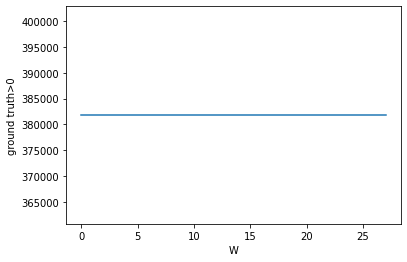

In [130]:
_, all_labels = training_dataset.get_data()
print(all_labels.shape)
# D_stack = make_2d_stack_from_3d(all_labels.unsqueeze(1), "D")
# print(D_stack.shape)
sum_over_w = torch.sum(all_labels, dim=(0,1,2))
plt.xlabel("W")
plt.ylabel("ground truth>0")
plt.plot(sum_over_w);

In [131]:
if config_dict['do_plot']:
    # Print bare 2D data
    # print("Displaying 2D bare sample")
    # for img, label in zip(training_dataset.img_data_2d.values(), 
    #                       training_dataset.label_data_2d.values()):
    #     display_seg(in_type="single_2D",
    #                 img=img.unsqueeze(0), 
    #                 ground_truth=label,
    #                 crop_to_non_zero_gt=True,
    #                 alpha_gt = .3)
        
    # Print transformed 2D data
    # train_subset = torch.utils.data.Subset(training_dataset,range(2))
    # training_dataset.train()
    # print("Displaying 2D training sample")
    # for sample in train_subset:
    #     display_seg(in_type="single_2D",
    #                 img=sample['image'].unsqueeze(0), 
    #                 ground_truth=sample['label'],
    #                 crop_to_non_zero_gt=True,
    #                 alpha_gt = .0)
    
    # Print transformed 3D data
    training_dataset.train()
    print("Displaying 3D training sample")
    leng = 10# training_dataset.__len__(yield_2d_override=False)
    for idx in range(leng):
        # training_dataset.set_dilate_kernel_size(1)
        sample = training_dataset.get_3d_item(idx)
        print(f"Sample {idx} ###")
        print("Unmodified sample")
        display_seg(in_type="single_3D", reduce_dim="W",
                    img=sample['image'].unsqueeze(0), 
                    ground_truth=sample['label'],
                    crop_to_non_zero_gt=True,
                    alpha_gt = .3)
        print(sample['label'].unique().item())
        
        print("Modified sample")
        # training_dataset.set_dilate_kernel_size(7)
        display_seg(in_type="single_3D", reduce_dim="W",
                    img=sample['image'].unsqueeze(0), 
                    ground_truth=sample['modified_label'],
                    crop_to_non_zero_gt=True,
                    alpha_gt = .3)
        print(sample['modified_label'].unique().item())
        print()


In [132]:
if config_dict['do_plot']:
    for sidx in [1,]:
        print(f"Sample {sidx}:")
        
        training_dataset.eval()
        sample_eval = training_dataset.get_crossmoda_3d_item(sidx)

        display_seg(in_type="single_3D", reduce_dim="W", 
                    img=sample_eval['image'].unsqueeze(0), 
                    ground_truth=sample_eval['label'],
                    crop_to_non_zero_gt=True,
                    alpha_gt = .3)
        
        display_seg(in_type="single_3D", reduce_dim="W", 
                    img=sample_eval['image'].unsqueeze(0), 
                    ground_truth=sample_eval['label'], 
                    crop_to_non_zero_gt=True,
                    alpha_gt = .0)

        training_dataset.train()
        print("Train sample with ground-truth overlay")
        sample_train = training_dataset.get_crossmoda_3d_item(sidx)
        print(sample_train['label'].unique())
        display_seg(in_type="single_3D", reduce_dim="W", 
                    img=sample_train['image'].unsqueeze(0), 
                    ground_truth=sample_train['label'], 
                    crop_to_non_zero_gt=True,
                    alpha_gt=.3)

        print("Eval/train diff with diff overlay")
        display_seg(in_type="single_3D", reduce_dim="W", 
                    img=(sample_eval['image'] - sample_train['image']).unsqueeze(0), 
                    ground_truth=(sample_eval['label'] - sample_train['label']).clamp(min=0), 
                    crop_to_non_zero_gt=True,
                    alpha_gt = .3)

In [133]:
# train_subset = torch.utils.data.Subset(training_dataset,range(2))
if config_dict['do_plot']:
    train_plotset = (training_dataset.get_crossmoda_3d_item(idx) for idx in (55, 81, 63))
    for sample in train_plotset:
        print(f"Sample {sample['dataset_idx']}:")
        display_seg(in_type="single_3D", reduce_dim="W", 
            img=sample_eval['image'].unsqueeze(0), 
            ground_truth=sample_eval['label'],
            crop_to_non_zero_gt=True,
            alpha_gt = .6)
        display_seg(in_type="single_3D", reduce_dim="W", 
            img=sample_eval['image'].unsqueeze(0), 
            ground_truth=sample_eval['label'],
            crop_to_non_zero_gt=True,
            alpha_gt = .0)

In [134]:
#Add functions to replace modules of a model

import functools
MOD_GET_FN = lambda self, key: self[int(key)] if isinstance(self, nn.Sequential) \
                                              else getattr(self, key)

def get_module(module, keychain):
    """Retrieves any module inside a pytorch module for a given keychain.
       module.named_ to retrieve valid keychains for layers.
    """

    return functools.reduce(MOD_GET_FN, keychain.split('.'), module)

def set_module(module, keychain, replacee):
    """Replaces any module inside a pytorch module for a given keychain with "replacee".
       Use get_named_layers_leaves(module) to retrieve valid keychains for layers.
    """
    
    key_list = keychain.split('.')
    root = functools.reduce(MOD_GET_FN, key_list[:-1], module)
    leaf = key_list[-1]
    if isinstance(root, nn.Sequential):
        root[int(leaf)] = replacee
    else:
        setattr(root, leaf, replacee)

In [135]:
def save_model(lraspp, optimizer, scaler, _path):
    
    torch.save(lraspp.state_dict(), _path + '_lraspp.pth')    
    torch.save(optimizer.state_dict(), _path + '_optimizer.pth')
    torch.save(scaler.state_dict(), _path + '_grad_scaler.pth')

    # TODO add saving inst/class parameters again
    # torch.save(inst_parameters, _path + '_inst_parameters.pth')
    # torch.save(class_parameters, _path + '_class_parameters.pth')

    
    
def get_model(config, dataset_len, _path=None):
    if config.use_mind:
        in_channels = 12
    else:
        in_channels = 1

    lraspp = torchvision.models.segmentation.lraspp_mobilenet_v3_large(
        pretrained=False, progress=True, num_classes=len(config.label_tags)
    )
    set_module(lraspp, 'backbone.0.0', 
               torch.nn.Conv2d(in_channels, 16, kernel_size=(3, 3), stride=(2, 2), 
                               padding=(1, 1), bias=False)
    )
        
    optimizer = torch.optim.Adam(lraspp.parameters(), lr=config.lr)
    
    scaler = amp.GradScaler()
    
    if _path and os.path.isfile(_path + '_lraspp.pth'):
        print(f"Loading lr-aspp model, optimizers and grad scalers from {_path}")
        # TODO add loading of data parameters
        lraspp.load_state_dict(torch.load(_path + '_lraspp.pth', map_location='cuda'))

        optimizer.load_state_dict(torch.load(_path + '_optimizer.pth', map_location='cuda'))
        scaler.load_state_dict(torch.load(_path + '_grad_scaler.pth', map_location='cuda'))
    else:
        print("Generating fresh lr-aspp model, optimizer and grad scaler.")
        
    return (lraspp, optimizer, scaler)

In [141]:
def get_global_idx(fold_idx, epoch_idx, max_epochs):
    # Get global index e.g. 2250 for fold_idx=2, epoch_idx=250 @ max_epochs<1000
    return 10**len(str(int(max_epochs)))*fold_idx + epoch_idx
        
    
            
def log_data_parameters(log_path, parameter_idxs, parameters):
    data = [[idx, param] for (idx, param) in \
        zip(parameter_idxs, torch.exp(parameters).tolist())]

    table = wandb.Table(data=data, columns = ["parameter_idx", "value"])
    wandb.log({log_path:wandb.plot.bar(table, "parameter_idx", "value", title=log_path)})
    

    
def calc_inst_parameters_in_target_pos_ratio(dpm, disturbed_inst_idxs, target_pos='min'):
    
    assert target_pos == 'min' or target_pos == 'max', "Value of target_pos must be 'min' or 'max'."
    descending = False if target_pos == 'min' else True
    
    target_len = len(disturbed_inst_idxs)
    
    disturbed_params = dpm.get_parameter_list(inst_keys=disturbed_inst_idxs)
    all_params = sorted(dpm.get_parameter_list(inst_keys='all'), reverse=descending)
    target_param_ids = [id(param) for param in all_params[:target_len]]
    
    ratio = [1. for param in disturbed_params if id(param) in target_param_ids]
    ratio = sum(ratio)/target_len
    return ratio
    
    
    
# def get_largest_data_parameters_in_target_ratio(parameter_idxs, parameters, target_idxs):
#     # print("param_idxs", parameter_idxs)
#     # print("parameters", parameters)
#     # print("target_idxs", target_idxs)
#     data = [[inst_idx, val] for (inst_idx, val) in \
#         zip(parameter_idxs, torch.exp(parameters).tolist())]
    
#     topk_cont_idxs = torch.argsort(parameters, descending=True)[:len(target_idxs)]
#     # print("topk_cont_idxs", topk_cont_idxs)
#     topk_dataset_idxs = parameter_idxs[topk_cont_idxs]
#     # print("topk_dataset_idxs", topk_dataset_idxs)
#     ratio = np.sum(np.in1d(topk_dataset_idxs, target_idxs))/len(target_idxs)
    
#     return ratio



def log_data_parameter_stats(log_path, epx, data_parameters):
    """Log stats for data parameters on wandb."""
    data_parameters = data_parameters.exp()
    wandb.log({f'{log_path}/highest': torch.max(data_parameters).item()}, step=epx)
    wandb.log({f'{log_path}/lowest': torch.min(data_parameters).item()}, step=epx)
    wandb.log({f'{log_path}/mean': torch.mean(data_parameters).item()}, step=epx)
    wandb.log({f'{log_path}/std': torch.std(data_parameters).item()}, step=epx)

    
    
def reset_determinism():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    # torch.use_deterministic_algorithms(True)
    
    
    
def log_class_dices(log_prefix, log_postfix, class_dices, log_idx):
    for cls_name in class_dices[0].keys():
        log_path = f"{log_prefix}{cls_name}{log_postfix}"

        cls_dices = list(map(lambda dct: dct[cls_name], class_dices))
        mean_per_class =np.nanmean(cls_dices)
        print(log_path, f"{mean_per_class*100:.2f}%")
        wandb.log({log_path: mean_per_class}, step=log_idx)

In [150]:
def train_DL(run_name, config, training_dataset):
    reset_determinism()

    # Configure folds
    kf = KFold(n_splits=config.num_folds)
    kf.get_n_splits(training_dataset)
    
    fold_iter = enumerate(kf.split(training_dataset))

    if config.only_first_fold:
        fold_iter = list(fold_iter)[0:1]
    
    if config.wandb_mode != 'disabled':
        # Log dataset info
        training_dataset.eval()
        dataset_info = [[smp['dataset_idx'], smp['_id'], smp['image_path'], smp['label_path']] \
                        for smp in training_dataset]
        wandb.log({'datasets/training_dataset':wandb.Table(columns=['dataset_idx', '_id', 'image', 'label'], data=dataset_info)}, step=0)
 
    fold_means_no_bg = []

    for fold_idx, (train_idxs, val_idxs) in fold_iter:
        train_idxs = torch.tensor(train_idxs)
        val_idxs = torch.tensor(val_idxs)
        
        # Training happens in 2D, validation happens in 3D:
        # Read 2D dataset idxs which are used for training, 
        # get their 3D super-ids by 3d dataset length
        # and substract these from all 3D ids to get val_3d_idxs
        trained_3d_dataset_idxs = {dct['3d_dataset_idx'] \
             for dct in training_dataset.get_id_dicts() if dct['2d_dataset_idx'] in train_idxs.tolist()}
        val_3d_idxs = set(range(training_dataset.__len__(yield_2d_override=False))) - trained_3d_dataset_idxs
        print("Will run validation with these 3D samples:", val_3d_idxs)
        
        ### Disturb dataset ###
        disturbed_idxs = np.random.choice(train_idxs, size=int(len(train_idxs)*config.disturbed_percentage), replace=False)
        disturbed_idxs = torch.tensor(disturbed_idxs)
        
        clean_idxs = train_idxs[np.isin(train_idxs, disturbed_idxs, invert=True)]
        print("Disturbed indexes:", sorted(disturbed_idxs.tolist()))
        
        if clean_idxs.numel() < 200:
            print(f"Clean indexes: {sorted(clean_idxs.tolist())}")

        wandb.log({f'datasets/disturbed_idxs_fold{fold_idx}':wandb.Table(columns=['train_idxs'], data=[[idx] for idx in disturbed_idxs])}, 
            step=get_global_idx(fold_idx, 0, config.epochs))
        
        ### Visualization ###
        if config.do_plot:
            print("Disturbed samples:")
            for d_idx in disturbed_idxs:
                display_seg(in_type="single_3D", reduce_dim="W", 
                    img=training_dataset[d_idx][0], 
                    ground_truth=disturb_seg(training_dataset[d_idx][1]),
                    crop_to_non_zero_gt=True,
                    alpha_gt = .0)
        
        ### Configure MIND ###
        if config.use_mind:
            in_channels =12
        else:
            in_channels = 1
            
        _, all_segs = training_dataset.get_data()

        # TODO add class weights again
        # class_weight = torch.sqrt(1.0/(torch.bincount(all_segs.long().view(-1)).float()))
        # class_weight = class_weight/class_weight.mean()
        # class_weight[0] = 0.15
        # class_weight = class_weight.cuda()
        # print('inv sqrt class_weight', class_weight)
        
        ### Add train sampler and dataloaders ##
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idxs)
        # val_subsampler = torch.utils.data.SubsetRandomSampler(val_idxs)

        train_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, 
            sampler=train_subsampler, pin_memory=True, drop_last=False,
            collate_fn=training_dataset.get_efficient_augmentation_collate_fn())
        training_dataset.unset_augment_at_collate()
#         val_dataloader = DataLoader(training_dataset, batch_size=config.val_batch_size, 
#                                     sampler=val_subsampler, pin_memory=True, drop_last=False)
      
        ### Get model, data parameters, optimizers for model and data parameters, as well as grad scaler ###
        (lraspp, optimizer, scaler) = get_model(config, len(train_dataloader), _path=None)#f"{config.mdl_save_prefix}_fold{fold_idx}") # TODO start fresh set _path None
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=200, T_mult=2, eta_min=config.lr*.1, last_epoch=- 1, verbose=False)
        
        lraspp.cuda()
        dpm = DataParameterManager(train_idxs.tolist(), config.label_tags, 
            config=config.data_parameter_config, device='cuda')
        
        # criterion = nn.CrossEntropyLoss(class_weight)
        # criterion = nn.CrossEntropyLoss()
        criterion = nn.BCEWithLogitsLoss()

        t0 = time.time()

        for epx in range(config.epochs):
            global_idx = get_global_idx(fold_idx, epx, config.epochs)
        
            lraspp.train()
            training_dataset.train()

            ### Disturb samples ###
            do_disturb = epx > config.start_disturbing_after_ep
            wandb.log({"do_disturb": float(do_disturb)}, step=global_idx)

            if do_disturb:
                training_dataset.set_disturbed_idxs(disturbed_idxs)
            else:
                training_dataset.set_disturbed_idxs([])
                
            epx_losses = []
            dices = []
            class_dices = []
            
            # Load data
            for batch in train_dataloader:
                
                b_img = batch['image']
                b_seg = batch['label']
                b_seg_modified = batch['modified_label']
                b_idxs_dataset = batch['dataset_idx']

                b_img = b_img.float().cuda()
                b_seg_modified = b_seg_modified.cuda()
        
                b_seg = b_seg.cuda()
    
                if config.use_mind:
                    b_img = mindssc(b_img.unsqueeze(1).unsqueeze(1)).squeeze(2)

                ### Forward pass ###
                with amp.autocast(enabled=True):
                    assert b_img.dim() == 4, \
                        f"Input image for model must be 4D: BxCxHxW but is {b_img.shape}"
                    
                    logits = lraspp(b_img)['out']

                    ### Check dimensions ###
                    assert logits.dim() == 4, \
                        f"Logits shape must be BxNUM_CLASSESxHxW but is {logits.shape}"
                    assert b_seg_modified.dim() == 3, \
                        f"Target shape for loss must be BxHxW but is {b_seg_modified.shape}"

                    dp_logits, loss_value = dpm.do_basic_train_step(
                        criterion, logits.permute(0,2,3,1), 
                        torch.nn.functional.one_hot(b_seg_modified, len(config.label_tags)), 
                        optimizer, inst_keys=b_idxs_dataset.tolist(), scaler=scaler)
    
                epx_losses.append(loss_value)
                
                # Prepare logits for scoring
                logits_for_score = logits.argmax(1) # TODO Check logits ok or dp_logits instead?

                # Calculate dice score
                b_dice = dice2d(
                    torch.nn.functional.one_hot(logits_for_score, len(config.label_tags)),
                    torch.nn.functional.one_hot(b_seg, len(config.label_tags)), # Calculate dice score with original segmentation (no disturbance)
                    one_hot_torch_style=True
                )

                dices.append(get_batch_dice_over_all(
                    b_dice, exclude_bg=False))
                class_dices.append(get_batch_dice_per_class(
                    b_dice, config.label_tags, exclude_bg=False))
                
                if config.do_plot:
                    print("Training 2D stack image label/ground-truth")
                    print(b_dice)
                    
                    display_seg(in_type="batch_2D", 
                        img=batch['image'].unsqueeze(1).cpu(), 
                        seg=logits_for_score.cpu(),
                        ground_truth=b_seg.cpu(),
                        crop_to_non_zero_seg=True,
                        crop_to_non_zero_gt=True,
                        alpha_seg=.1,
                        alpha_gt =.2
                    )
                    
                if config.debug:
                    break
                    
                ###  Scheduler management ###
                if config.use_cosine_annealing:
                    scheduler.step()

                # if scheduler.T_cur == 0:
                #     sz = training_dataset.get_dilate_kernel_size()
                #     training_dataset.set_dilate_kernel_size(sz-1)
                #     print(f"Current dilate kernel size is {training_dataset.get_dilate_kernel_size()}.")

            ### Logging ###
            if epx % config.log_every == 0 or (epx+1 == config.epochs):
                
                print(f"### Log epoch {epx} @ {time.time()-t0:.2f}")
                print("### Training")
                ### Log wandb data ###
                # Log the epoch idx per fold - so we can recover the diagram by setting 
                # ref_epoch_idx as x-axis in wandb interface
                wandb.log({"ref_epoch_idx": epx}, step=global_idx)
                
                mean_loss = torch.tensor(epx_losses).mean()
                wandb.log({f'losses/loss_fold{fold_idx}': mean_loss}, step=global_idx)
                
                mean_dice = np.nanmean(dices)
                print(f'dice_mean_wo_bg_fold{fold_idx}', f"{mean_dice*100:.2f}%")
                                   
                log_class_dices("scores/dice_mean_", f"_fold{fold_idx}", class_dices, global_idx)
            
                if (not dpm.disabled) and (dpm.data_param_mode == DataParamMode.ONLY_INSTANCE_PARAMS):
                    # Log instance parameters of all samples
                    log_data_parameter_stats(f"data_parameters/instances/all_fold{fold_idx}", global_idx, 
                            dpm.get_parameter_tensor(inst_keys='all').detach()
                    )

                    # Log instance parameters of disturbed samples
                    if disturbed_idxs.numel() > 0:
                        param_dict = dpm.get_data_parameters_dict()

                        log_data_parameter_stats(f"data_parameters/instances/disturbed_fold{fold_idx}", 
                            global_idx, 
                            dpm.get_parameter_tensor(inst_keys=disturbed_idxs.tolist()).detach()
                        )

                        log_data_parameter_stats(f"data_parameters/instances/clean_fold{fold_idx}", 
                            global_idx, 
                            dpm.get_parameter_tensor(inst_keys=clean_idxs.tolist()).detach()
                        )

                        # Calculate ratio of data parameters in topN disturbed (is 1.0 if every disturbed
                        # sample gets the highest data parameter)
                        min_param_ratio = calc_inst_parameters_in_target_pos_ratio(dpm, disturbed_idxs.tolist(), 'min')
                        max_param_ratio = calc_inst_parameters_in_target_pos_ratio(dpm, disturbed_idxs.tolist(), 'max')
         
                        print(f'inst_param_ratio_min_fold{fold_idx}', min_param_ratio)
                        print(f'inst_param_ratio_max_fold{fold_idx}', max_param_ratio)
                        wandb.log(
                            {f'data_parameters/inst_param_ratio_min_fold{fold_idx}': min_param_ratio}, 
                            step=global_idx
                        )
                        wandb.log(
                            {f'data_parameters/inst_param_ratio_max_fold{fold_idx}': max_param_ratio}, 
                            step=global_idx
                        )
                        
                print()
                print("### Validation")                                    
                lraspp.eval()
                training_dataset.eval()   
                # TODO remove saving 
                # save_model(lraspp, inst_parameters, class_parameters, 
                #     optimizer, optimizer_inst_param, optimizer_class_param, 
                #     scaler, f"{config.mdl_save_prefix}_fold{fold_idx}")
                
                with amp.autocast(enabled=True):
                    with torch.no_grad():
                        val_dices = []
                        val_class_dices = []
                        
                        for val_idx in val_3d_idxs:
                            val_sample = training_dataset.get_3d_item(val_idx)
                            stack_dim = training_dataset.yield_2d_normal_to
                            # Create batch out of single val sample
                            b_val_img = val_sample['image'].unsqueeze(0)
                            b_val_seg = val_sample['label'].unsqueeze(0)
                            
                            B = b_val_img.shape[0]

                            b_val_img = b_val_img.unsqueeze(1).float().cuda()
                            b_val_seg = b_val_seg.cuda()
                            b_val_img_2d = make_2d_stack_from_3d(b_val_img, stack_dim=stack_dim)
                            
                            if config.use_mind:
                                b_val_img_2d = mindssc(b_val_img_2d.unsqueeze(1)).squeeze(2)
                                
                            output_val = lraspp(b_val_img_2d)['out']

                            # Prepare logits for scoring
                            # Scoring happens in 3D again - unstack batch tensor again to stack of 3D
                            val_logits_for_score = make_3d_from_2d_stack(output_val, stack_dim, B)
                            val_logits_for_score = val_logits_for_score.argmax(1)

                            b_val_dice = dice3d(
                                torch.nn.functional.one_hot(val_logits_for_score, len(config.label_tags)),
                                torch.nn.functional.one_hot(b_val_seg, len(config.label_tags)), 
                                one_hot_torch_style=True
                            )
                            
                            # Get mean score over batch
                            val_dices.append(get_batch_dice_over_all(
                                b_val_dice, exclude_bg=False))
                            
                            val_class_dices.append(get_batch_dice_per_class(
                                b_val_dice, config.label_tags, exclude_bg=False))
                
                            if config.do_plot:
                                print(f"Validation 3D image label/ground-truth {val_3d_idxs}")
                                print(b_val_dice)
                                # display_all_seg_slices(b_seg.unsqueeze(1), logits_for_score)
                                display_seg(in_type="single_3D", 
                                    reduce_dim="W",
                                    img=val_sample['image'].unsqueeze(0).cpu(), 
                                    seg=val_logits_for_score.squeeze(0).cpu(),
                                    ground_truth=b_val_seg.squeeze(0).cpu(),
                                    crop_to_non_zero_seg=True,
                                    crop_to_non_zero_gt=True,
                                    alpha_seg=.4,
                                    alpha_gt=.2
                                )
                        mean_val_dice = np.nanmean(val_dices)
                        print(f'val_dice_mean_wo_bg_fold{fold_idx}', f"{mean_val_dice*100:.2f}%")
                        wandb.log({f'scores/val_dice_mean_wo_bg_fold{fold_idx}': mean_val_dice}, step=global_idx)
                    
                        log_class_dices("scores/val_dice_mean_", f"_fold{fold_idx}", val_class_dices, global_idx)
                  
                print()
                # End of logging
                
            if config.debug:
                break
        
        # End of fold loop
        if dpm.data_param_mode == DataParamMode.ONLY_INSTANCE_PARAMS:
            inst_parameters = dpm.get_parameter_tensor(inst_keys=train_idxs.tolist()).detach() # TODO simplify logging
            log_data_parameters(f"data_parameters/instance_parameters_fold{fold_idx}", train_idxs, inst_parameters)

        lraspp.cpu()
        
        save_model(lraspp,optimizer, scaler, f"{config.mdl_save_prefix}_fold{fold_idx}") # TODO save data parameter manager

In [151]:
config_dict['debug'] = False
config_dict['wandb_mode'] = 'disabled'
config_dict['batch_size'] = 16
print(len(training_dataset))

run = wandb.init(project="curriculum_deeplab", group="training", job_type="train",
    config=config_dict, settings=wandb.Settings(start_method="thread"),
    mode=config_dict['wandb_mode']
)
run_name = run.name
config = wandb.config

train_DL(run_name, config, training_dataset)
wandb.finish()

2800
Will run validation with these 3D samples: {0, 1, 2, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39}
Disturbed indexes: []
Generating fresh lr-aspp model, optimizer and grad scaler.
### Log epoch 0 @ 12.18
### Training
dice_mean_wo_bg_fold0 9.96%
scores/dice_mean_liver_fold0 9.96%
scores/dice_mean_kidney-right_fold0 8.91%
scores/dice_mean_kidney-left_fold0 8.94%
scores/dice_mean_femur-right_fold0 9.54%
scores/dice_mean_femur-left_fold0 10.56%
scores/dice_mean_bladder_fold0 10.26%
scores/dice_mean_heart_fold0 9.50%
scores/dice_mean_lung-right_fold0 10.49%
scores/dice_mean_lung-left_fold0 12.99%
scores/dice_mean_spleen_fold0 15.11%
scores/dice_mean_pancreas_fold0 22.49%

### Validation
val_dice_mean_wo_bg_fold0 5.18%
scores/val_dice_mean_liver_fold0 5.18%
scores/val_dice_mean_kidney-right_fold0 6.65%
scores/val_dice_mean_kidney-left_fold0 0.20%
scores/val_dice_mean_femur-right_fold0 0.00%
scores/val_dice_mean_fe

KeyboardInterrupt: 

In [ ]:
def inference_DL(run_name, config, inf_dataset):

    score_dicts = []
    
    fold_iter = range(config.num_folds)
    if config_dict['only_first_fold']:
        fold_iter = fold_iter[0:1]
        
    for fold_idx in fold_iter:
        lraspp, *_ = load_model(f"{config.mdl_save_prefix}_fold{fold_idx}", config, len(validation_dataset))

        lraspp.eval()
        inf_dataset.eval()   
        stack_dim = config.yield_2d_normal_to
        
        inf_dices = []
        inf_dices_tumour = []
        inf_dices_cochlea = []
        
        for inf_sample in inf_dataset:
            global_idx = get_global_idx(fold_idx, sample_idx, config.epochs)
            crossmoda_id = sample['crossmoda_id']
            with amp.autocast(enabled=True):
                with torch.no_grad():

                    # Create batch out of single val sample
                    b_inf_img = inf_sample['image'].unsqueeze(0)
                    b_inf_seg = inf_sample['label'].unsqueeze(0)

                    B = b_inf_img.shape[0]

                    b_inf_img = b_inf_img.unsqueeze(1).float().cuda()
                    b_inf_seg = b_inf_seg.cuda()
                    b_inf_img_2d = make_2d_stack_from_3d(b_inf_img, stack_dim=stack_dim)

                    if config.use_mind:
                        b_inf_img_2d = mindssc(b_inf_img_2d.unsqueeze(1)).squeeze(2)

                    output_inf = lraspp(b_inf_img_2d)['out']

                    # Prepare logits for scoring
                    # Scoring happens in 3D again - unstack batch tensor again to stack of 3D
                    inf_logits_for_score = make_3d_from_2d_stack(output_inf, stack_dim, B)
                    inf_logits_for_score = inf_logits_for_score.argmax(1)

                    inf_dice = dice3d(
                        torch.nn.functional.one_hot(inf_logits_for_score, 3),
                        torch.nn.functional.one_hot(b_inf_seg, 3), 
                        one_hot_torch_style=True
                    )
                    inf_dices.append(get_batch_dice_wo_bg(inf_dice))
                    inf_dices_tumour.append(get_batch_dice_tumour(inf_dice))
                    inf_dices_cochlea.append(get_batch_dice_cochlea(inf_dice))

                    if config.do_plot:
                        print("Inference 3D image label/ground-truth")
                        print(inf_dice)
                        # display_all_seg_slices(b_seg.unsqueeze(1), logits_for_score)
                        display_seg(in_type="single_3D", 
                            reduce_dim="W",
                            img=inf_sample['image'].unsqueeze(0).cpu(), 
                            seg=inf_logits_for_score.squeeze(0).cpu(),
                            ground_truth=b_inf_seg.squeeze(0).cpu(),
                            crop_to_non_zero_seg=True,
                            crop_to_non_zero_gt=True,
                            alpha_seg=.4,
                            alpha_gt=.2
                        )
                        
            if config.debug:
                break
                
        mean_inf_dice = np.nanmean(inf_dices)
        mean_inf_dice_tumour = np.nanmean(inf_dices_tumour)
        mean_inf_dice_cochlea = np.nanmean(inf_dices_cochlea)

        print(f'inf_dice_mean_wo_bg_fold{fold_idx}', f"{mean_inf_dice*100:.2f}%")
        print(f'inf_dice_mean_tumour_fold{fold_idx}', f"{mean_inf_dice_tumour*100:.2f}%")
        print(f'inf_dice_mean_cochlea_fold{fold_idx}', f"{mean_inf_dice_cochlea*100:.2f}%")
        wandb.log({f'scores/inf_dice_mean_wo_bg_fold{fold_idx}': mean_inf_dice}, step=global_idx)
        wandb.log({f'scores/inf_dice_mean_tumour_fold{fold_idx}': mean_inf_dice_tumour}, step=global_idx)
        wandb.log({f'scores/inf_dice_mean_cochlea_fold{fold_idx}': mean_inf_dice_cochlea}, step=global_idx)

        # Store data for inter-fold scoring
        class_dice_list = inf_dices.tolist()[0]
        for class_idx, class_dice in enumerate(class_dice_list):
            score_dicts.append(
                {
                    'fold_idx': fold_idx,
                    'crossmoda_id': crossmoda_id,
                    'class_idx': class_idx,
                    'class_dice': class_dice,
                }
            )

    mean_oa_inf_dice = np.nanmean(torch.tensor([score['class_dice'] for score in score_dicts]))
    print(f"Mean dice over all folds, classes and samples: {mean_oa_inf_dice*100:.2f}%")
    wandb.log({'scores/mean_dice_all_folds_samples_classes': mean_oa_inf_dice}, step=global_idx)

    return score_dicts

In [ ]:
folds_scores = []
run = wandb.init(project="curriculum_deeplab", name=run_name, group=f"testing", job_type="test",
        config=config_dict, settings=wandb.Settings(start_method="thread"),
        mode=config_dict['wandb_mode']
)
config = wandb.config
score_dicts = inference_DL(run_name, config, validation_dataset)
folds_scores.append(score_dicts)
wandb.finish()